In [13]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from biodata.delimited import DelimitedReader, DelimitedWriter
import numpy as np
import seaborn as sns
import pybedtools
from statannotations.Annotator import Annotator
from statsmodels.stats.proportion import proportions_ztest
import hicstraw
import os
import itertools
from scipy.stats import mannwhitneyu
import json
import cooler
from cooltools import insulation
from collections import defaultdict
import sys
from pathlib import Path
from biodatatools.utils.common import json_load

In [3]:
matplotlib.font_manager.fontManager.addfont(f"{Path.cwd().parent}/font/Arial.ttf")
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9

In [4]:
sys.path.append(f"{Path.cwd().parent}")
import utils

In [5]:
PROJECT_DIR_d = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/PROcap/"
PROJECT_DIR_r = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/"
PROJECT_DIR_o = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/"

# Loop frequency

## Get loop anchors

In [6]:
s = "HCT116"
ps = ["divergent", "unidirectional"]
ds = ["distal", "proximal"]
t = "minTSS"
labels = ["Up", "Unchanged"]
palette = ["#fec44f", "#d9d9d9"]

In [7]:
# chrom1, start, end, chrom2, start2, end2, PET count

inputfile = f"{PROJECT_DIR_r}ENCODE/ENCFF431BUN.bedpe.gz"
df_loop = pd.read_table(inputfile, header=None)
df_loop.head(2)

,0,1,2,3,4,5,6
0,chr10,66135,66716,chr10,76204,77233,3
1,chr10,76316,77462,chr10,86211,87169,4


In [8]:
# They submitted ChIA-PET loop file with PET count ≥ 3 to ENCODE

np.min(df_loop[6])

3

In [9]:
# It's okay to overlap with either anchor

outputfile = f"{PROJECT_DIR_o}temp/CTCF_loops.bed"
with DelimitedWriter(outputfile) as dw:
	for index, row in df_loop.iterrows():
		chrom, start, end, chrom2, start2, end2 = row[:-1]
		dw.write([chrom, start, end])
		dw.write([chrom2, start2, end2])

In [10]:
b1 = pybedtools.BedTool(f"{PROJECT_DIR_o}FIMO/{s}_CTCF_pos.bed")
b2 = pybedtools.BedTool(f"{PROJECT_DIR_o}temp/CTCF_loops.bed")
overlaps = b1.intersect(b2, u=True, f=1)
anchors = ["_".join(i.fields[:3]) for i in overlaps]

In [11]:
len(b1), len(anchors)

(3518, 2913)

## Get proportions

In [14]:
motifs = json_load(f"{PROJECT_DIR_o}FIMO/{s}_CTCF_pos.json")

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


In [15]:
DE_labels = json_load(f"{PROJECT_DIR_o}labels/{s}_CTCF_DE.json")

In [16]:
results = []
es = defaultdict(list)
for p, d in itertools.product(ps, ds):
	inputfile = f"{PROJECT_DIR_d}bed_plot/{s}_{p}_{d}.bed"
	with DelimitedReader(inputfile) as dr:
		for cols in dr:
			e = "_".join(cols[:3])
			if e in motifs and e in DE_labels[t]:
				es[d].append(e)
				e2 = f"{cols[0]}_{motifs[e][1]}_{motifs[e][2]}"
				if e2 in anchors:
					anchor = True
				else:
					anchor = False
				results.append([d, anchor, DE_labels[t][e]])
df_anchors = pd.DataFrame(results, columns=["Group", "Anchor", "Label"])
df_anchors.head(2)

,Group,Anchor,Label
0,distal,True,Unchanged
1,distal,True,Unchanged


In [17]:
# Proportion of elements with CTCF located at the loop with PET count ≥ 3

results = []
for d, label in itertools.product(ds, labels):
	df = df_anchors[(df_anchors["Group"]==d) & (df_anchors["Label"]==label)]
	results.append([d, label, len(df[df["Anchor"]==True]), len(df), len(df[df["Anchor"]==True])/len(df)*100])
df_prop = pd.DataFrame(results, columns=["Group", "Label", "No. anchors", "Total", "Proportion"])
df_prop.head(2)

,Group,Label,No. anchors,Total,Proportion
0,distal,Up,197,208,94.711538
1,distal,Unchanged,993,1171,84.799317


In [18]:
def plot_props(df, outputfile):
	fig, ax = plt.subplots(figsize=(1.8,2.2))
	hue_plot_params = {
						"data": df,
						"x": "Label",
						"y": "Proportion",
						"palette": palette,
						"hue": "Label",
						"legend": False,
						"alpha": 0.8
						}
	g = sns.barplot(ax=ax, **hue_plot_params)
	g.spines[["right", "top"]].set_visible(False)
	
	texts = []
	for label in labels:
		for index, row in df[df["Label"]==label].iterrows():
			texts.append(f"{row['No. anchors']}/{row['Total']}")
	for bar, text in zip(g.patches, texts):
		g.text(bar.get_x(), bar.get_height()+1, text, color="#000000", fontsize=sfontsize) 

	g.set_ylim([70,102])
	g.set_yticks([70,80,90,100])
	g.set_ylabel("TREs at loop anchors (%)", fontsize=bfontsize)
	g.tick_params(axis="y", labelsize=sfontsize)

	g.set_xlabel("")
	g.tick_params(axis="x", labelsize=bfontsize)
	
	pvalues = []
	successes = list(df["No. anchors"])
	nobs = list(df["Total"])
	x1, x2 = [0,1]
	pvalues.append(proportions_ztest([successes[x1], successes[x2]], [nobs[x1], nobs[x2]])[1])
	annotator = Annotator(g, [labels], **hue_plot_params)
	annotator.configure(text_format="star", verbose=False, text_offset=1, loc="outside", fontsize=sfontsize)
	annotator.set_pvalues(pvalues).annotate()

	plt.savefig(outputfile, bbox_inches="tight", transparent=True)

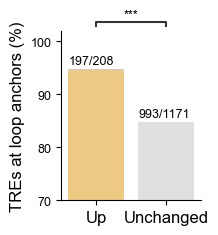

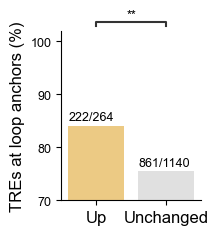

In [19]:
for d in ds:
	folder = "figures/" if d == "distal" else "other_figures/"
	outputfile = f"{PROJECT_DIR_o}{folder}ExtDataFig8f.pdf"
	plot_props(df_prop[df_prop["Group"]==d], outputfile)

# Insulation score

## Convert .hic to .cool

In [17]:
# https://github.com/deeptools/HiCExplorer/issues/821
# https://github.com/open2c/cooler-binder/blob/master/cooler_cli.ipynb

def hic2cool(hic_file, cool_file, data_type, normalization, resolution):
	hic = hicstraw.HiCFile(hic_file)
	chrom_sizes = pd.Series({chrom.name: chrom.length for chrom in hic.getChromosomes() if chrom.name != "All"})
	
	with open(hic.getGenomeID() + '.size', 'w') as fsize:
	    for chrom in hic.getChromosomes():
	        if chrom.name != "All":
	            fsize.write(f"{chrom.name}\t{chrom.length}\n")

	with open(cool_file.replace('.cool', ".txt"), 'w') as fo:
	    for i in range(len(chrom_sizes)):
	        for j in range(i, len(chrom_sizes)):
	            chrom1 = chrom_sizes.index[i]
	            chrom2 = chrom_sizes.index[j]
				# Fetch a list of all the raw contacts on between chrom1 and chrom2 at XXX resolution
	            result = hicstraw.straw(data_type, normalization, hic_file, chrom1, chrom2, 'BP', resolution)
	            for k in range(len(result)):
	                start1 = result[k].binX
	                start2 = result[k].binY
	                value = result[k].counts
	                fo.write(f"{chrom1}\t{start1}\t{start1}\t{chrom2}\t{start2}\t{start2}\t{value}\n")
	
	# Create a cooler from a pre-binned matrix.
	os.system(f"cooler load -f bg2 {hic.getGenomeID()}.size:{resolution} {cool_file.replace('.cool', '.txt')} {cool_file}")
	# Matrix balancing 
	os.system(f"cooler balance -p 10 {cool_file}")

In [20]:
hic_file = f"{PROJECT_DIR_r}ENCODE/ENCFF573OPJ.hic"
cool_file = f"{PROJECT_DIR_r}ENCODE/ENCFF573OPJ.cool"
data_type = "observed"
normalization = "NONE"
resolution = 10000

In [ ]:
# This takes quite long time to run...

hic2cool(hic_file, cool_file, data_type, normalization, resolution)

INFO:cooler.cli.load:fields: {'chrom1': 0, 'start1': 1, 'end1': 2, 'chrom2': 3, 'start2': 4, 'end2': 5, 'count': 6}
INFO:cooler.cli.load:dtypes: {'chrom1': <class 'str'>, 'start1': <class 'int'>, 'end1': <class 'int'>, 'chrom2': <class 'str'>, 'start2': <class 'int'>, 'end2': <class 'int'>, 'count': <class 'numpy.int32'>}
INFO:cooler.cli.load:symmetric-upper: True
INFO:cooler.create:Writing chunk 0: /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/ENCODE/tmp4vj7x_47.multi.cool::0
INFO:cooler.create:Creating cooler at "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/ENCODE/tmp4vj7x_47.multi.cool::/0"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Writing chunk 1: /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/ENCODE/tmp4vj7x_47.multi.cool::1
INFO:cooler.create:Creating cooler 

In [21]:
# Check the output

! cooler dump --header --balanced $PROJECT_DIR_r/ENCODE/ENCFF573OPJ.cool | awk 'NR==1 || $4 != ""' | head -n 3

bin1_id	bin2_id	count	balanced
87	87	587	0.481977
87	88	264	0.161714


## Get insulation scores

In [22]:
# https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1012067
# https://cooltools.readthedocs.io/en/latest/notebooks/insulation_and_boundaries.html

clr = cooler.Cooler(f"{PROJECT_DIR_r}ENCODE/ENCFF573OPJ.cool")
windows = [3*resolution]
df_ins = insulation(clr, windows, verbose=True)
outputfile = f"{PROJECT_DIR_o}temp/ENCFF573OPJ.insulation_score.txt"
df_ins.to_csv(outputfile, sep="\t", index=False)

INFO:root:fallback to serial implementation.
INFO:root:Processing region chr1
INFO:root:Processing region chr2
INFO:root:Processing region chr3
INFO:root:Processing region chr4
INFO:root:Processing region chr5
INFO:root:Processing region chr6
INFO:root:Processing region chr7
INFO:root:Processing region chr8
INFO:root:Processing region chr9
INFO:root:Processing region chr10
INFO:root:Processing region chr11
INFO:root:Processing region chr12
INFO:root:Processing region chr13
INFO:root:Processing region chr14
INFO:root:Processing region chr15
INFO:root:Processing region chr16
INFO:root:Processing region chr17
INFO:root:Processing region chr18
INFO:root:Processing region chr19
INFO:root:Processing region chr20
INFO:root:Processing region chr21
INFO:root:Processing region chr22
INFO:root:Processing region chrX
INFO:root:Processing region chrY
INFO:root:Processing region chrM


In [23]:
df_ins.head(2)

,chrom,start,end,region,is_bad_bin,log2_insulation_score_30000,n_valid_pixels_30000,boundary_strength_30000,is_boundary_30000
0,chr1,0,10000,chr1,True,NaN,0.0,NaN,False
1,chr1,10000,20000,chr1,True,NaN,0.0,NaN,False


In [24]:
# Anchor on the bin containing a given CTCF motif; 10 bins on both sides for plotting

n_bins = 20
df_features = {}
for d in ds:
	results = []
	index = []
	for e in es[d]:
		chrom = e.split("_")[0]
		mut_start = motifs[e][1]
		ind = mut_start//resolution
		df = df_ins[df_ins["chrom"]==chrom].reset_index(drop=True)
		if not np.isnan(df.loc[ind][f"log2_insulation_score_{windows[0]}"]) and not df.loc[ind]["is_bad_bin"]:
			values = df.loc[ind-n_bins//2:ind+n_bins//2+1, f"log2_insulation_score_{windows[0]}"].tolist()
			index.append(e)
			results.append(values)
	df_features[d] = pd.DataFrame(results, index=index)

In [25]:
for d in ds:
	print(d, len(es[d]), len(df_features[d]))

distal 1394 1384
proximal 1421 1403


In [26]:
df_reformat = {}
for d in df_features:
	df = df_features[d].reset_index()
	df_reformat[d] = pd.melt(df,
						  id_vars="index",
						  value_vars=list(df.columns[1:]),
						  var_name="Position",
						  value_name="Feature"
						  )
	df_reformat[d]["Label"] = df_reformat[d]["index"].map(DE_labels[t])

In [27]:
# Get the score of the middle bin for each element
# Get the average values for two groups; U test 

values = {}
d = "distal"
for label in labels:
	df = df_reformat[d][(df_reformat[d]["Label"]==label) & (df_reformat[d]["Position"]==10)]
	values[label] = df["Feature"].tolist()

In [28]:
np.mean(values[labels[0]]), np.mean(values[labels[1]]), mannwhitneyu(values[labels[0]], values[labels[1]]).pvalue

(-0.26476178914408693, -0.07412761501053704, 2.199335314072725e-07)

In [29]:
def plot_scores(df, outputfile, test=False):
	fig, ax = plt.subplots(figsize=(2.5,2.5))
	utils.generate_feature_metaplot(df, palette, labels, ax, test)
	ax.spines[["right", "top"]].set_visible(False)
	ax.legend(title="", loc="lower left", fontsize=sfontsize, frameon=False)

	ax.set_ylabel("log$_2$(Insulation score)", fontsize=bfontsize)
	ax.set_ylim([-0.5,0.3])
	
	ax.set_xlabel("Distance (kb)", fontsize=bfontsize)
	xtick_list = [5*n for n in range(5)]
	xticklabel_list = [-10*resolution//1000, -5*resolution//1000, 0, 5*resolution//1000, 10*resolution//1000]
	ax.set_xticks(xtick_list)
	ax.set_xticklabels(xticklabel_list)
	
	ax.tick_params(labelsize=sfontsize)
	
	plt.savefig(outputfile, bbox_inches="tight", transparent=True)

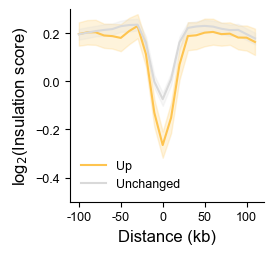

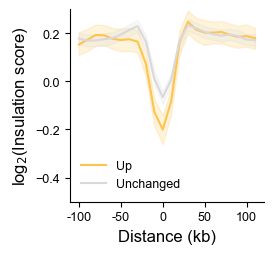

In [30]:
for d in ds:
	folder = "figures/" if d == "distal" else "other_figures/"
	outputfile = f"{PROJECT_DIR_o}{folder}ExtDataFig8g.pdf"
	plot_scores(df_reformat[d], outputfile)